# Load data

In [26]:
import pandas as pd
import numpy as np
from utils.currency_dataframe import CurrencyDataframe
import matplotlib.pyplot as plt

csvFile = r'..\data\global_inflation_data.csv'
currencyDf = CurrencyDataframe(csvFile).get_dataframe()

# Model based on cumulative inflation

## Brazil dataframe

### Creating dataframe

In [ ]:
dfBrazil = currencyDf[currencyDf['country_name'] == 'Brazil']

In [15]:
dfBrazil.head()

,country_name,Year,Inflation,Currency,cumulative_inflation
3160,Brazil,1996,15.8,BRL,15.8
3356,Brazil,1997,6.9,BRL,22.7
3552,Brazil,1998,3.2,BRL,25.9
3748,Brazil,1999,4.9,BRL,30.8
3944,Brazil,2000,7.0,BRL,37.8


### Data visualization

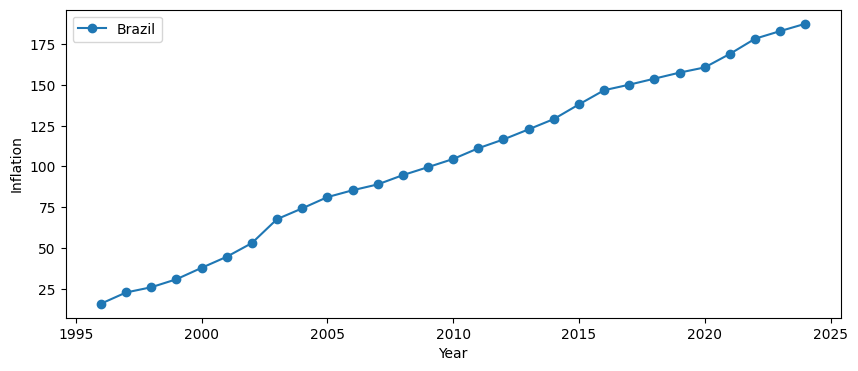

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(dfBrazil['Year'], dfBrazil['cumulative_inflation'], label='Brazil', marker='o')
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend(loc='upper left')
plt.show()

### Linear Regression Model

In [21]:
type(dfBrazil['Year'].to_frame())

pandas.core.frame.DataFrame

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dfBrazil['Year'].to_frame(), dfBrazil['cumulative_inflation'].to_frame(), test_size=0.3, random_state=23)
print(f'Exemplos para o treinamento: {len(y_train)}. E para o teste: {len(y_test)}')

Exemplos para o treinamento: 20. E para o teste: 9


In [30]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [32]:
# mse = mean_squared_error(y_test,y_pred, squared=True)  || Deprecated
mae = mean_absolute_error(y_test,y_pred)
mse = root_mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,y_pred)

print(f'MAE: {mae} - MSE: {mse} - RMSE: {rmse} - MAPE: {mape}')

MAE: 3.21281083192262 - MSE: 4.022249743864565 - RMSE: 2.0055547222313743 - MAPE: 0.055827172076636344


#### Output model

In [33]:
import joblib

joblib.dump(model, './output/modelLinearBrazil.pkl')

['./output/modelLinearBrazil.pkl']

# Running Streamlit

streamlit run streamlit/app.py